In [60]:
# Imports
import pandas as pd
import numpy as np
from pydub import AudioSegment
import noisereduce as nr
import soundfile as sf
from pydub.playback import play

import matplotlib.pyplot as plt
from scipy.signal import spectrogram

import ipywidgets as widgets
from IPython.display import display

In [5]:
# Load the audio file
audio_file = "../Keystrokes_1.wav"  # Replace with your audio file path
data, sample_rate = sf.read(audio_file)

In [6]:
# Reduce noise
reduced_noise = nr.reduce_noise(y=data, sr=sample_rate, prop_decrease=.75)

# Save the cleaned audio to a new file
output_file = "../cleaned_output.wav"
sf.write(output_file, reduced_noise, sample_rate)

audio = AudioSegment.from_wav(output_file)

In [29]:
# Process audio into segments

# Create a list to hold the keystroke segments
keystroke_segments = []
keystroke_times = []
threshold = 20

# Define a function to calculate RMS energy
def calculate_rms(segment):
    return np.sqrt(np.mean(np.square(segment.get_array_of_samples())))

# Analyze the audio in small chunks
chunk_size = 200  # Size of each chunk in milliseconds
for start in range(0, len(audio), chunk_size):
    segment = audio[start:start + chunk_size]
    if calculate_rms(segment) > threshold:  # Define a suitable threshold
        keystroke_segments.append(segment)
        keystroke_times.append((start, start + chunk_size))


# Now you can work with the keystroke segments
# For example, you can export each segment to a file
#for i, segment in enumerate(keystroke_segments):
    #print(i)
    #play(segment)

print(f"Extracted {len(keystroke_segments)} keystroke segments.")

Extracted 277 keystroke segments.


[0.00000000e+00 2.08355037e-05 4.16710074e-05 ... 1.99958329e-01
 1.99979164e-01 2.00000000e-01]


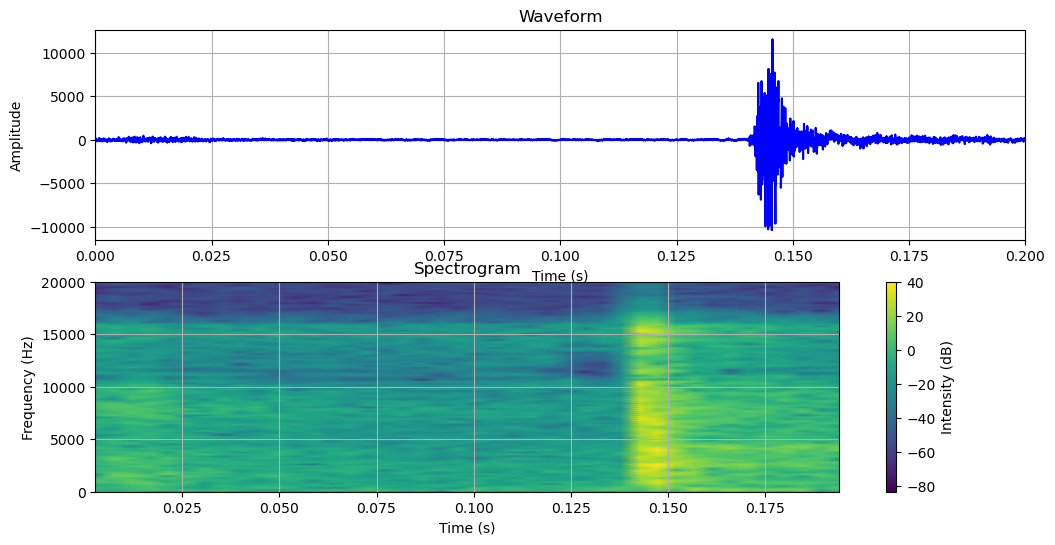

In [58]:
# Display audio segment
audio_segment = keystroke_segments[60]
audio_segment_time = keystroke_times[60][0]

def display_audio(audio, audio_start=None, times=None):
    samples = np.array(audio.get_array_of_samples())
    # Handles stereo
    if audio.channels == 2:
        samples = samples.reshape((-1, 2))
    
    # Create a time array for the x-axis
    time = np.linspace(0, len(samples) / audio.frame_rate, num=len(samples))
    if audio_start is not None:
        start = audio_start / 1000.
        time = np.linspace(start, len(samples) / audio.frame_rate, num=len(samples))
    print(time)

    # Plotting the waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, samples, color='blue')
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(time[0], time[-1])
    plt.grid()

    if times is not None:
        for start, end in times:
            plt.axvspan(start/1000, end/1000, color='red', alpha=0.5)  # Adjust color and transparency
            plt.axvline(x=start/1000, color='black', linestyle='--', linewidth=1)  # Start line
            plt.axvline(x=end/1000, color='black', linestyle='--', linewidth=1)    # End line


    # Create a spectrogram
    frequencies, times, Sxx = spectrogram(samples[:], fs=audio.frame_rate)  # Use one channel for spectrogram

    # Plotting the spectrogram
    plt.subplot(2, 1, 2)
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    plt.title('Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar(label='Intensity (dB)')
    plt.ylim(0, 20000)  # Limit frequency range to 20 kHz for better visibility
    plt.grid()

    plt.show()


display_audio(audio_segment)
play(audio_segment)

C:\Users\nmcph\AppData\Local\Temp\ipykernel_18424\4153018291.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')


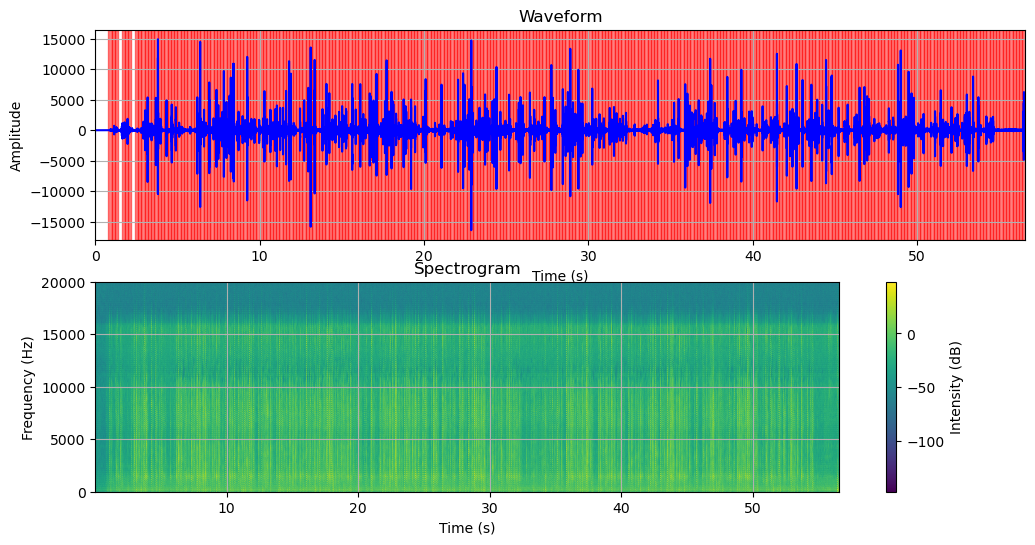

In [34]:
display_audio(audio, keystroke_times)

[0.8        0.80000694 0.80001389 ... 1.19998611 1.19999306 1.2       ]


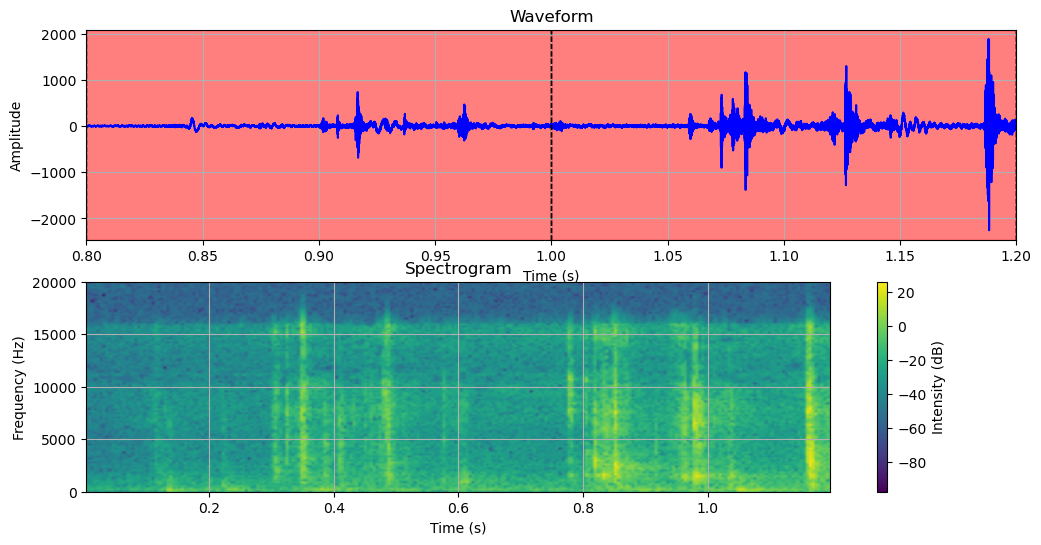

In [59]:
audio_segment = audio[800:2000]
display_audio(audio_segment, audio_start=800, times=keystroke_times)
play(audio_segment)

In [97]:
# Segments the audio into keystrokes based on a threshold value (amplitude)
def segment_audio(audio: AudioSegment, threshold):
    samples = np.array(audio.get_array_of_samples())
    sample_rate = audio.frame_rate

    if audio.channels == 2:
        samples = samples.reshape((-1, 2))
    
    segments_over_threshold = []
    
    for i, sample in enumerate(samples):
        if sample > threshold:
            segments_over_threshold.append((i, sample))
    
    keystroke_segments = get_segments_over_threshold(samples, segments_over_threshold, threshold, sample_rate)
    return keystroke_segments

# Uses the segments over the threshold to create audio clips of each keystroke
def get_segments_over_threshold(samples, segments, threshold, sample_rate):
    j = -1
    prev_n = -1
    threshold_max_gap = .5 * sample_rate
    min_seg_length = .1 * sample_rate

    # Contains tuples with (start, end)
    keystroke_times = []

    # Get the start and end times for each keystroke
    for n, _ in segments:
        if j == -1:
            j = n
        else:
            # If there is more than a certain amount of time between the current and the previous sample over the threshold, end the keystroke segment at the previous sample
            if n - j >= threshold_max_gap:
                # Only save the segment if it is more than min_seg_length samples long
                if n - j > min_seg_length:
                    keystroke_times.append((j, prev_n))
                j = n
        prev_n = n
    
    keystrokes = []
    for k_start, k_end in keystroke_times:
        keystrokes.append(samples[k_start:k_end])
    return keystrokes


keystrokes = segment_audio(audio, 50)
# Maybe just modify the first version of keystroke extraction

In [98]:
print(len(keystrokes))

110


[0.00000000e+00 2.08355037e-05 4.16710074e-05 ... 1.99958329e-01
 1.99979164e-01 2.00000000e-01]


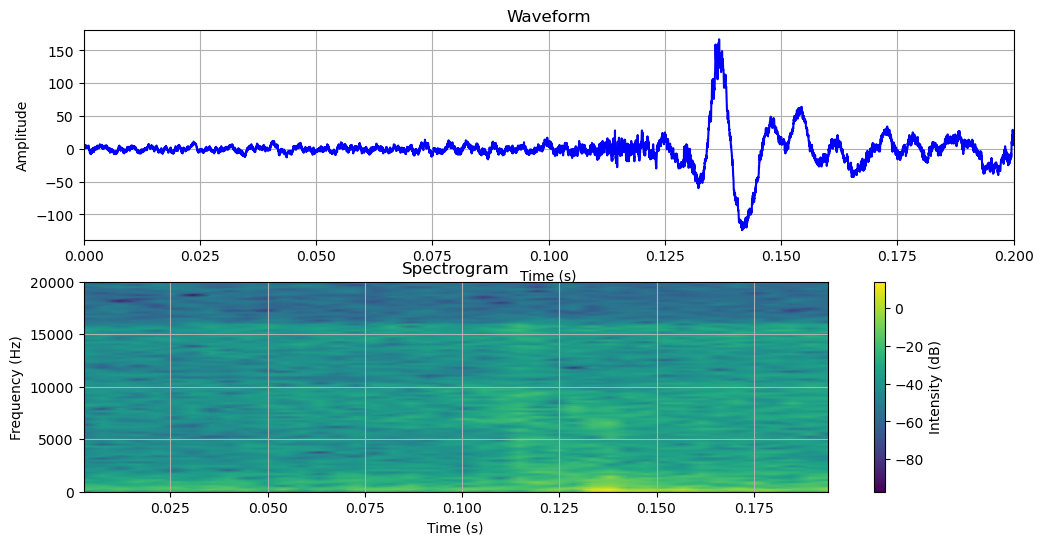

In [ ]:
display_audio(keystroke_segments[0])

In [152]:
"""
Written by Shoyo Inokuchi (June 2019)

Scripts for the acoustic keylogger surrounding feature extraction.
Repository is located at: https://github.com/shoyo-inokuchi/acoustic-keylogger
"""
from librosa.feature import mfcc


def extract_features(keystroke, sr=44100, n_mfcc=16, n_fft=441, hop_len=110):
    """Return an MFCC-based feature vector for a given keystroke."""
    spec = mfcc(y=keystroke.astype(float),
                sr=sr,
                n_mfcc=n_mfcc,
                n_fft=n_fft, # n_fft=220 for a 10ms window
                hop_length=hop_len, # hop_length=110 for ~2.5ms
                )
    return spec.flatten()

In [162]:
# make a pandas DataFrame from all of the keystroke samples

def convert_to_array(list_of_keys):
    list_of_arrays = []
    for key in list_of_keys:
        key_array = np.array(key.get_array_of_samples())
        list_of_arrays.append(extract_features(key_array, sr=key.frame_rate))
    
    return list_of_arrays

key_df = pd.DataFrame(convert_to_array(keystroke_segments))
print(key_df.shape)

# Replace nan values in the last keystroke
key_df.fillna(0, inplace=True)

key_df.head()

c:\Users\nmcph\anaconda3\envs\heimdall\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


(277, 1408)


,0,1,2,3,4,5,6,7,8,9,...,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407
0,18.260808,38.836056,28.715691,46.754522,48.274031,42.712572,44.571656,48.280274,49.430179,52.774199,...,-17.604555,-18.097362,-20.380397,-13.382484,-18.371495,-21.961507,-21.317269,-19.106580,-22.703001,-15.212903
1,106.264020,129.812316,117.386145,110.692328,113.016740,112.914340,111.670536,109.385176,108.631948,131.226890,...,-19.586583,-11.415062,-15.136439,-17.575746,-22.453472,-21.536815,-17.004056,-9.654996,-7.788373,-2.919988
2,221.084016,196.489334,167.416491,180.597449,259.585613,280.945036,246.610000,213.456918,203.782732,194.007632,...,-11.093478,-23.903142,-18.513477,-17.024664,-14.299038,-23.192274,-21.701778,-18.234987,-18.851247,-13.515868
3,177.106467,247.380055,272.920986,293.979618,262.485351,236.046451,235.284859,295.045484,365.693406,377.784145,...,-24.583405,-26.464271,-25.872277,-20.173539,-26.830267,-31.652715,-29.471051,-30.287338,-23.488846,-3.525670
4,262.574109,282.454172,271.741885,261.024967,263.262401,260.784296,256.257039,244.462201,253.127925,260.241082,...,-31.793086,-27.422227,-18.469070,-20.743992,-23.735186,-27.017303,-22.804580,-15.184653,-19.045443,-17.432969


In [160]:
# Perform k-means clustering on the keystrokes
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=30, random_state=0, n_init="auto").fit(key_df.to_numpy())

predicted_clusters = []
for keystroke in key_df.to_numpy():
    predicted_clusters.append(kmeans.predict(keystroke.reshape(1, -1)))

predicted_clusters = np.array(predicted_clusters).squeeze()

c:\Users\nmcph\anaconda3\envs\heimdall\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


(277, 1408)


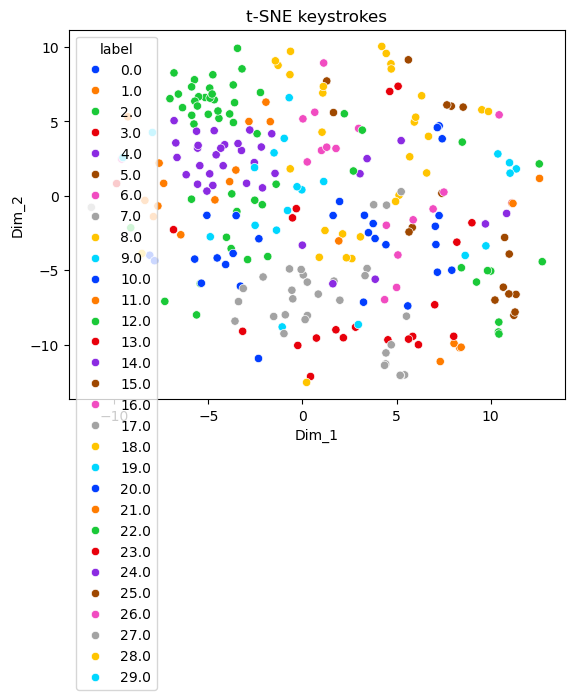

In [161]:
# Plot the data with t-SNE dimensionality reduction to determine if the keystrokes make clusters

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sn

# Scale data
standardized_data = StandardScaler().fit_transform(key_df)
print(standardized_data.shape)

def tsne_plot(data, labels=None):
    model = TSNE(n_components = 2, random_state = 0)
    # configuring the parameters
    # the number of components = 2
    # default perplexity = 30
    # default learning rate = 200
    # default Maximum number of iterations
    # for the optimization = 1000
    
    tsne_data = model.fit_transform(data)
    
    # Colors points based on their label, if they have any
    if labels is not None:
        tsne_data = np.vstack((tsne_data.T, labels)).T
        tsne_df = pd.DataFrame(data = tsne_data,
           columns =("Dim_1", "Dim_2", "label"))
    
        # Plotting the result of tsne
        sn.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
                       hue='label', palette="bright")
    else:
        tsne_df = pd.DataFrame(data = tsne_data,
           columns =("Dim_1", "Dim_2"))
    
        # Plotting the result of tsne
        sn.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2', palette="bright")

    plt.title("t-SNE keystrokes")
    plt.show()

tsne_plot(standardized_data, predicted_clusters)